In [2]:
print(not "0")

False


In [5]:
print(set([{"A":1}]))

TypeError: unhashable type: 'dict'

In [ ]:
import os
configs=[]#List of configs to give to PSG later
nSamples=100
atmosphereType="A1"
configFolder=r"C:\Users\Tristan\Downloads\HyPCAR3\configs"
for i,starSample in enumerate([[i]*nSamples for i in range(1,4)]):
    for counter,sample in enumerate(starSample):
        configNum=(i*nSamples)+counter+1#+1 because counter starts at 0
        configFileName=os.path.join(configFolder,f"{atmosphereType}_{configNum}.txt")
        
        print(configFileName)

In [14]:
from pyDOE import lhs
import numpy as np
gStarParamRanges = {
'starRad': (0.8, 1.3),
'starTemp': (5000, 6000),
'Kappa': (-3.5, -2.0),
'Gamma1': (-1.5,  1.1),
'Gamma2': (-1.5,  0.),
'alpha': ( 0.,   1.),
'Albedo':(0.1, 0.8),
'Distance': (1.3,15.)}
lhsSamples=lhs(len(gStarParamRanges),20000)#A list of 8 values 5 times
# scaledSamples=np.zeros_like(lhsSamples)
# print(scaledSamples)

In [2]:
import os
# configFileName=os.path.join(configFolder,f"{atmosphereType}_{configNum}.txt")
print(os.path.join("/home/tristanb/scratch/configFiles", f"A1_{12}.txt"))

/home/tristanb/scratch/configFiles\A1_12.txt


In [2]:
print(20000%32)

0


In [8]:
import numpy as np
def calculateMoleculeAbundances():
    knownValues=np.random.uniform(0,0.001,size=7)#Known moleecule abundancese
    totalKnown=np.sum(knownValues)
    remainingAbundance=1-totalKnown

    backgroundAbundances=np.random.dirichlet(np.ones(3))*remainingAbundance
    print(knownValues)
    print(backgroundAbundances)
    print(list(knownValues)+list(backgroundAbundances))
calculateMoleculeAbundances()

[4.59424601e-04 7.97090207e-04 9.61223096e-05 7.29339462e-04
 4.31713947e-04 9.31741703e-04 5.35175233e-04]
[0.58825567 0.11706405 0.29069968]
[0.0004594246007181554, 0.0007970902069920539, 9.612230962150569e-05, 0.0007293394623348403, 0.00043171394712927694, 0.0009317417027060772, 0.0005351752327408323, 0.5882556661946974, 0.11706405042602595, 0.29069967591703405]


: 

In [7]:
from scipy.stats import lognorm,norm,spearmanr, pearsonr
molecules=["O2","N2","H2","CO2","H2O","CH4","NH3"]
'''
Contains H2O, CH4, NH3, H2/N2
        Lacks CO2, O2
'''
detectionOutput=[0.3,0.6,0.4,0.1,0.7,0.8,0.9]
predAbun=[1,2,2,0,4,5,6]
# predAbun=[0.45,0.001,0.1,0.001,0.30,0.001,0.2]

spearman,p=spearmanr(detectionOutput,predAbun)
pearson,p2=pearsonr(detectionOutput,predAbun)
print((spearman,pearson))
detectionLoss=(1-spearman)+(1-pearson)
print(detectionLoss)

(0.9910312089651149, 0.9617780776627134)
0.04719071337217173


In [3]:
test=[1000,0.43,321]
total=sum(test)
temp=[val/total for val in test]


1.0


In [6]:
import torch
import numpy as np
def calculateLikelihood(yReal,ySim,sigma):
    '''
    This function calculates the likelhood P(A_pred|Y_real). It is a gaussian likelihood function.

    Inputs
    ------
    yReal: Real, input transmittance data
    ySim: Simulated transmittance data, calculated using the predicted abundances
    sigma: Uncertainty of how well predicted abundances translate to simulated spectra

    Returns
    -------
    likelihood: Likelihood value for given real and simulated data
    '''

    mse = torch.mean((yReal - ySim)**2,dim=1)  #Mean squared error between real and simulated data
    #return np.exp(-mse / (2 * sigma ** 2))
    nll = mse / (2 * sigma**2)
    nll_aggregated = torch.mean(nll, dim=[0,1])  # shape: (B,)
    return nll_aggregated




def classifyAtmosphere(predAbun):
    '''
    This function calculates the H, O, C and N values from the predicted abundances
    Then based on the mixing ratios, we will classify what type of atmosphere it is

    Inputs
    ------
    predAbun: The predicted abundances. A list of 7 values, representing the abundance of each molecule

    
    Returns
    -------
    atmosphereType: A value from the list [A1,A2,B,C]
    '''
    #The order of the molecules
    molecules={0:"O2",1:"N2",2:"H2",3:"CO2",4:"H2O",5:"CH4",6:"NH3"}

    #H = 2*H2 + 2*H2O + 3*NH3 + 4*CH4
    abundanceDict={}
    for i,val in enumerate(predAbun):
        abundanceDict[molecules[i]]=val

    H=2*abundanceDict["H2"] + 2*abundanceDict["H2O"] + 3*abundanceDict["NH3"] + 4*abundanceDict["CH4"]

    C=abundanceDict["CO2"] + abundanceDict["CH4"]

    O=2*abundanceDict["O2"] + 2*abundanceDict["CO2"] + abundanceDict["H2O"]

    N=2*abundanceDict["N2"] + abundanceDict["NH3"]

    if H> 2*O + 4*C:
        if 3*N < H - 2*O - 4*C:
            return "A1"
        else:
            return "A2"
        
    elif 2*O > H + 4*C:
        return "B"
    
    elif abs(H + C + O + N - 1) < 1e-3:  # Hydrogen-poor constraint
        return "C"

    else:
        return "Unkown"


def calculateExpectedValues(predAbun):
    #First figure out what type of atmosphere the model think it is
    #Either A1, A2, B, C or unkown
    atmosphereType=classifyAtmosphere(predAbun)

    molecules={0:"O2",1:"N2",2:"H2",3:"CO2",4:"H2O",5:"CH4",6:"NH3"}
    abundanceDict={}
    for i,val in enumerate(predAbun):
        abundanceDict[molecules[i]]=val

    H=2*abundanceDict["H2"] + 2*abundanceDict["H2O"] + 3*abundanceDict["NH3"] + 4*abundanceDict["CH4"]

    C=abundanceDict["CO2"] + abundanceDict["CH4"]

    O=2*abundanceDict["O2"] + 2*abundanceDict["CO2"] + abundanceDict["H2O"]

    N=2*abundanceDict["N2"] + abundanceDict["NH3"]

    expected={}
    if atmosphereType=="A1":
        #For Type A1 atmospheres (H-rich, mainly H2O, CH4, NH3, and H2; lacking CO2, O2)
        '''
        H > 2O + 4C
        3N < H - 2O -4C

        D = H - N - 2C
        H2O = 2O / D
        NH3 = 2N / D
        CH4 = 2C / D
        H2 = (H - 2O - 4C - 3N) / D
        '''
        D = H - N - 2*C
        expected["H2O"]=2*O / D
        expected["NH3"]=2*N / D
        expected["CH4"]=2*C / D
        expected["H2"]=(H - 2*O - 4*C - 3*N) / D

        expected["O2"]=0
        expected["N2"]=0
        expected["CO2"]=0

    elif atmosphereType=="A2":
        #For Type A2 atmospheres (H-rich, but mainly H2O, CH4, NH3, and N2; lacking CO2, O2)
        '''
        D = H + 2C + 3N + 4O
        H2O = 6O / D
        NH3 = (2H - 8C - 4O) / D
        CH4 = 6C / D
        N2 = (3N + 4C + 2O - H) / D
        '''
        D = H + 2*C + 3*N + 4*O
        expected["H2O"]=6*O / D
        expected["NH3"]=(2*H - 8*C - 4*O) / D
        expected["CH4"]=6*C / D
        expected["N2"] =(3*N + 4*C + 2*O - H) / D

        expected["O2"]=0
        expected["H2"]=0
        expected["CO2"]=0

    elif atmosphereType=="B":
        #For Type B atmospheres (O-rich, mainly O2, N2, CO2, H2O; lacking NH3, H2)
        '''
        D = H + 2O + 2N
        H2O = 2H / D
        N2 = 2N / D
        CO2 = 4C / D
        O2 = (2O - H - 4C) /D
        '''
        D = H + 2*O + 2*N
        expected["H2O"]=2*H / D
        expected["N2"]=2*N / D
        expected["CO2"]=4*C / D
        expected["O2"]=(2*O - H - 4*C) / D

        expected["NH3"]=0
        expected["H2"]=0
        expected["CH4"]=0
    elif atmosphereType=="C":
        #For Type C atmospheres (Hydrogen-poor: mainly H2O, CO2, CH4, N2; lacking NH3, H2, O2)
        #Note: In Type C, the elemental budget is H + C + O + N = 1.
        '''
        Side conditions, so no negative results
        O > 0.5H + 2C -> O2-rich with no CH4
        H > 2O + 4C -> H2 ->H2-rich with no CO2
        C > 0.25H + 0.5O -> graphite condensation with no H2O

        H2O = (H + 2O - 4C) / (H + 2O + 2N)
        CH4 = (H - 2O + 4C) / (2H + 4O + 4N)
        CO2 = (2O + 4C - H) / (2H + 4O + 4N)
        N2 = 2N / (H + 2O + 2N)
        '''

        #Denom for H2O and N2
        D1 = H + 2*O + 2*N

        #Denom for CH4 and CO2
        D2 = 2*H + 4*O + 4*N  

        expected["H2O"] = (H + 2*O - 4*C) / D1
        expected["CH4"] = (H - 2*O + 4*C) / D2
        expected["CO2"] = (2*O + 4*C - H) / D2
        expected["N2"] = 2*N / D1

        expected["O2"] = 0
        expected["H2"] = 0
        expected["NH3"] = 0
    else:
        #Its unkown, prior should just be 1
        #So there is essentially no prior. Just want the likelihood
        return None
    return list(expected.values())

def calculatePrior(predAbun,sigmaPrior):
    '''
    predAbun: The predicted abundance for each moleecule
    sigmaPrior: The uncertainty for each molecule
    '''
    totalLoss=0.0
    batchSize=predAbun.shape[0]
    
    for i in range(batchSize):
        sampleLoss=0.0
        sampleAbundance=predAbun[i]
        sampleSigma=sigmaPrior[i]
        expectedValues=calculateExpectedValues(sampleAbundance.tolist())
        if expectedValues==None:
            totalLoss+=0
        else:
            for j in range(len(sampleAbundance)):
                mu=expectedValues[j]
                sigma=sampleSigma[j]

                y=sampleAbundance[j]
                sampleLoss+=np.log(np.sqrt(2 * np.pi) * sigma) + ((y - mu)**2) / (2 * sigma**2)
            totalLoss+=sampleLoss
    return totalLoss/batchSize



def calculatePosterior(yReal,ySim,sigmaLikelihood,predAbun,sigmaPrior):
    # Math: P({y_{real}}|A_{pred}) \propto P(A_{pred}|Y_{real}) * P(A_{pred})
    '''
    This function calculates the unnormalized posterior

    Inputs
    ------
    yReal: Real, input transmittance data
    ySim: Simulated transmittance data, calculated using the predicted abundances
    sigmaLikelihood: Uncertainty of how well predicted abundances translate to simulated spectra
    predAbun: Predicted abundances
    sigmaPrior: Uncertaintiy of the precicted abundances

    Returns
    -------
    posterior: Unnormalized posterior probability
    '''




    prior=calculatePrior(predAbun,sigmaPrior) 
    likelihood=calculateLikelihood(yReal,ySim,sigmaLikelihood)


    #For the likelihood, I should just take the aggregated transmittance. However, later if I want to include wavelength-molecule mapping, here is where I would do it.

    print(f"Likelihood: {likelihood}")
    print(f"Prior: {prior}")

    posterior=likelihood+prior
    return posterior

yReal=torch.tensor([[1,1,1,0.5,1,1,1],[1,1,1,0.5,1,1,1]])
ySim=torch.tensor([[0.8,0.8,0.8,0.5,0.9,0.75,1],[1,1,1,0.5,1,1,1]])
predAbun=torch.tensor(np.random.dirichlet(np.ones(7),size=2))

print(predAbun)
print(calculatePosterior(yReal,ySim,0.1,predAbun,torch.tensor([[0.5]*7]*2)))

tensor([[0.1184, 0.0724, 0.2376, 0.0635, 0.4451, 0.0159, 0.0471],
        [0.0865, 0.4684, 0.0110, 0.1217, 0.1837, 0.0218, 0.1070]],
       dtype=torch.float64)


IndexError: Dimension out of range (expected to be in range of [-1, 0], but got 1)

In [14]:
import random
import os

import torch
from torch.utils.data import DataLoader,Dataset,random_split
from tqdm import tqdm
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import time
def kl_divergence(predictions, targets):
    '''
    This function calculates the Kullback-Leibler (KL) divergence between the predictions and the target value.

    Inputs
    ------
    predictions: A tensor that represents the models predictions
    targets: A tensor that represents the ground truth for the model

    Returns
    -------
    klDivergenceLoss: A value between 0 and 1 that represents the KL divergence loss. A value of 0 is best.
    '''
    predictions_log=torch.log(predictions+1e-10)  #Adding a small value to avoid log(0)
    kl_div=F.kl_div(predictions_log, targets, reduction='batchmean')
    return kl_div.item()


def topKAccuracy(output,target,k=1):
    '''
    This functions calculates the top-K accuracy for the predicted abundance values.
    
    Inputs
    ------
    output: The output from the abundance model
    target: The target abundance values
    k: k value for top-k accuracy.
    
    Returns
    -------
    Top-k value as a percentage of the values that match.
    '''
    _,topKPred = output.topk(k, dim=1)
    
    # Get the indices of the top k true abundances
    _,topKTarget = target.topk(k, dim=1)
    
    #Compare predictions with true targets
    correct = (topKPred == topKTarget).sum().item()
    
    #Return the accuracy as a percentage
    return correct/(target.size(0) * k)


def customCrossEntropy(output, target):
    '''
    This function calculate the cross-entropy loss between the predicted abundances and the true abundances.

    Inputs
    ------
    output: The output from the abundance model
    target: The target abundance values

    Returns:
    cross_entropy_loss: The average cross-entropy loss for the batch.
    '''

    # Apply log to predictions (log-softmax is typically used to stabilize computation)
    log_predictions=torch.log(output + 1e-9)  # Adding a small value to prevent log(0)
    
    # Element-wise multiplication of log_predictions with targets
    elementwise_loss=-target * log_predictions
    
    # Sum over the molecules (dim=1) to get the loss for each example in the batch
    cross_entropy_loss=torch.sum(elementwise_loss, dim=1)
    
    # Average over the batch
    cross_entropy_loss=torch.mean(cross_entropy_loss)
    
    return cross_entropy_loss

def getAbundances(fileName):
    '''
    This function grabs the molecule abundances from the config files and returns them as a vector

    Inputs
    ------
    fileName: The name of the config file.

    Returns
    -------
    abundances: A vector containing the abundance information
    '''
    abundances=[0.0]*7
    moleculeNames=["O2", "N2", "CO2", "H2O", "N2O", "CH4", "H2S"]
    lines=[]
    with open(fileName) as f:
        for line in f:
            lines.append(line)

    abundances=lines[54]
    abundances=abundances.removeprefix("<ATMOSPHERE-LAYER-1>")
    abundances=abundances.split(",")

    if "None" in os.path.basename(fileName):
        #Special case
        abundances=list(map(float,abundances[2:9]))#Only gets target values, not background moolecules or 

    else:
        abundances=list(map(float,abundances[2:]))#Remove temperature profile information
    return abundances

class customDataset(Dataset):
    def __init__(self,samples):
        self.samples=samples
    def __len__(self):
        return len(self.samples)
    def __getitem__(self, index):
        return self.samples[index][0],self.samples[index][1]
start=time.time()
atmosphereTypes=["A","B","C"]
folderPath=r"C:\Users\Tristan\Downloads\HyPCAR3\data"
random.seed(42)

testingData=[]
testSplit=0.1


for atmosphere in atmosphereTypes:
    curFolderPath=folderPath+f"\\{atmosphere}"
    files=[]

    for path in os.listdir(curFolderPath):
        fileName=path.removesuffix(".csv")
        configFilePath=os.path.join(r"C:\Users\Tristan\Downloads\HyPCAR3\configFiles",fileName)
        
        configFilePath+=".txt"

        label=getAbundances(configFilePath)
        files.append((os.path.join(curFolderPath,path),label))

    random.shuffle(files)

    testingSamples=[]
    for i,data in enumerate(files):
        path,label=data[0],data[1]
        if i<(len(files)*testSplit):#Adds testing data
            testingSamples.append((os.path.join(curFolderPath,path),label))
        else:
            break
    testingData.extend(testingSamples)
random.shuffle(testingData)

testingDataset=customDataset(testingData)
testingDataloader=DataLoader(testingDataset,batch_size=1,shuffle=True)#Testing data loader


predictions=[]
targets=[]
for batch in tqdm(testingDataloader):
    
    data,labels=batch
    
    # print(labels.size())
    labels=[t.item() for t in labels]
    labels=torch.tensor(labels)
    
    random_numbers = np.random.dirichlet(np.ones(7))
    predictions.append(torch.tensor(random_numbers, dtype=torch.float32))
    targets.append(labels)

predictions=torch.stack(predictions)
targets=torch.stack(targets)


print(f"KL-divergence: {kl_divergence(predictions,targets)}")
testLoss=nn.MSELoss()
print(f"MSE Loss: {testLoss(predictions,targets)}")
print(f"Top-1 Accuracy: {topKAccuracy(predictions,targets)}")
print(f"Cross Entropy: {customCrossEntropy(predictions,targets)}")


print(time.time()-start)


100%|██████████| 18000/18000 [00:02<00:00, 8691.71it/s]


KL-divergence: 1.3801686763763428
MSE Loss: 0.05369268357753754
Top-1 Accuracy: 0.14283333333333334
Cross Entropy: 2.44124436378479
1229.487996339798


In [9]:
import random
import os

import torch
from torch.utils.data import DataLoader,Dataset,random_split
from tqdm import tqdm
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import time
from sklearn.metrics import r2_score
def kl_divergence(predictions, targets):
    '''
    This function calculates the Kullback-Leibler (KL) divergence between the predictions and the target value.

    Inputs
    ------
    predictions: A tensor that represents the models predictions
    targets: A tensor that represents the ground truth for the model

    Returns
    -------
    klDivergenceLoss: A value between 0 and 1 that represents the KL divergence loss. A value of 0 is best.
    '''
    predictions_log=torch.log(predictions+1e-10)  #Adding a small value to avoid log(0)
    kl_div=F.kl_div(predictions_log, targets, reduction='batchmean')
    return kl_div.item()


def topKAccuracy(output,target,k=1):
    '''
    This functions calculates the top-K accuracy for the predicted abundance values.
    
    Inputs
    ------
    output: The output from the abundance model
    target: The target abundance values
    k: k value for top-k accuracy.
    
    Returns
    -------
    Top-k value as a percentage of the values that match.
    '''
    _,topKPred = output.topk(k, dim=1)
    
    # Get the indices of the top k true abundances
    _,topKTarget = target.topk(k, dim=1)
    
    #Compare predictions with true targets
    correct = (topKPred == topKTarget).sum().item()
    
    #Return the accuracy as a percentage
    return correct/(target.size(0) * k)


def customCrossEntropy(output, target):
    '''
    This function calculate the cross-entropy loss between the predicted abundances and the true abundances.

    Inputs
    ------
    output: The output from the abundance model
    target: The target abundance values

    Returns:
    cross_entropy_loss: The average cross-entropy loss for the batch.
    '''

    # Apply log to predictions (log-softmax is typically used to stabilize computation)
    log_predictions=torch.log(output + 1e-9)  # Adding a small value to prevent log(0)
    
    # Element-wise multiplication of log_predictions with targets
    elementwise_loss=-target * log_predictions
    
    # Sum over the molecules (dim=1) to get the loss for each example in the batch
    cross_entropy_loss=torch.sum(elementwise_loss, dim=1)
    
    # Average over the batch
    cross_entropy_loss=torch.mean(cross_entropy_loss)
    
    return cross_entropy_loss

def getAbundances(fileName):
    '''
    This function grabs the molecule abundances from the config files and returns them as a vector

    Inputs
    ------
    fileName: The name of the config file.

    Returns
    -------
    abundances: A vector containing the abundance information
    '''
    abundances=[0.0]*7
    moleculeNames=["O2", "N2", "CO2", "H2O", "N2O", "CH4", "H2S"]
    lines=[]
    with open(fileName) as f:
        for line in f:
            lines.append(line)

    abundances=lines[54]
    abundances=abundances.removeprefix("<ATMOSPHERE-LAYER-1>")
    abundances=abundances.split(",")

    if "None" in os.path.basename(fileName):
        #Special case
        abundances=list(map(float,abundances[2:9]))#Only gets target values, not background moolecules or 

    else:
        abundances=list(map(float,abundances[2:]))#Remove temperature profile information
    return abundances

class customDataset(Dataset):
    def __init__(self,samples):
        self.samples=samples
    def __len__(self):
        return len(self.samples)
    def __getitem__(self, index):
        return self.samples[index][0],self.samples[index][1]
start=time.time()
atmosphereTypes=["A","B","C"]
folderPath=r"C:\Users\Tristan\Downloads\HyPCAR3\data"
random.seed(42)

testingData=[]
testSplit=0.1


targets=[]
counter=0

for atmosphere in atmosphereTypes:
    curFolderPath=folderPath+f"\\{atmosphere}"
    files=[]

    for path in os.listdir(curFolderPath):
        fileName=path.removesuffix(".csv")
        configFilePath=os.path.join(r"C:\Users\Tristan\Downloads\HyPCAR3\configFiles",fileName)
        
        configFilePath+=".txt"

        label=getAbundances(configFilePath)
        files.append((os.path.join(curFolderPath,path),label))

    random.shuffle(files)

    testingSamples=[]
    for i,data in enumerate(files):
        path,label=data[0],data[1]

        targets.append(label)
        counter+=1

        if i<(len(files)*testSplit):#Adds testing data
            testingSamples.append((os.path.join(curFolderPath,path),label))
        else:
            break
    testingData.extend(testingSamples)
random.shuffle(testingData)

testingDataset=customDataset(testingData)
testingDataloader=DataLoader(testingDataset,batch_size=1,shuffle=True)#Testing data loader

naivePrediction=np.mean(targets,axis=0)

predictions=[]
targets=[]
for batch in testingDataloader:
    data,labels=batch

    predictions.append(naivePrediction)
    targets.append(labels)
print(naivePrediction)
print(predictions)

targets=torch.tensor(targets)
predictions=torch.tensor(predictions)

print(f"KL-divergence: {kl_divergence(predictions,targets)}")
testLoss=nn.MSELoss()
print(f"MSE Loss: {testLoss(predictions,targets)}")
print(f"Top-1 Accuracy: {topKAccuracy(predictions,targets)}")
print(f"Cross Entropy: {customCrossEntropy(predictions,targets)}")


print(time.time()-start)


[0.09649595 0.27121701 0.05937794 0.15240005 0.23839517 0.11176736
 0.07034651]
[array([0.09649595, 0.27121701, 0.05937794, 0.15240005, 0.23839517,
       0.11176736, 0.07034651]), array([0.09649595, 0.27121701, 0.05937794, 0.15240005, 0.23839517,
       0.11176736, 0.07034651]), array([0.09649595, 0.27121701, 0.05937794, 0.15240005, 0.23839517,
       0.11176736, 0.07034651]), array([0.09649595, 0.27121701, 0.05937794, 0.15240005, 0.23839517,
       0.11176736, 0.07034651]), array([0.09649595, 0.27121701, 0.05937794, 0.15240005, 0.23839517,
       0.11176736, 0.07034651]), array([0.09649595, 0.27121701, 0.05937794, 0.15240005, 0.23839517,
       0.11176736, 0.07034651]), array([0.09649595, 0.27121701, 0.05937794, 0.15240005, 0.23839517,
       0.11176736, 0.07034651]), array([0.09649595, 0.27121701, 0.05937794, 0.15240005, 0.23839517,
       0.11176736, 0.07034651]), array([0.09649595, 0.27121701, 0.05937794, 0.15240005, 0.23839517,
       0.11176736, 0.07034651]), array([0.09649595, 

C:\Users\Tristan\AppData\Local\Temp\ipykernel_34188\1691168955.py:178: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)
  predictions=torch.tensor(predictions)


In [3]:
import numpy as np

def average_of_each_index(list_of_lists):
    array = np.array(list_of_lists)
    average_list = np.mean(array, axis=0)
    return average_list.tolist()

# Example usage
list_of_lists = [
    [1, 2, 3, 4, 5, 6, 7],
    [8, 9, 10, 11, 12, 13, 14],
    [15, 16, 17, 18, 19, 20, 21]
]

result = average_of_each_index(list_of_lists)
print(result)


[8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0]


In [ ]:
from scipy.stats import ttest_rel
import numpy as np
from sklearn.metrics import r2_score

naiveAVG=0
randomAVG=0

counter=0
for batch in tqdm(testingDataloader):
    path,label=batch
    naiveAVG+=r2_score(naive_predictions[0], label)

    
    label=torch.tensor([float(l) for l in label])
    random_numbers = torch.tensor(np.random.dirichlet(np.ones(7)))

    randomAVG+=r2_score(random_numbers, label)
    counter+=1
    

print(naiveAVG/counter)
print(randomAVG/counter)


KeyboardInterrupt: 

In [23]:

from sklearn.metrics import r2_score
import numpy as np
a1=[0.0,0.0,0.2772344370097009,0.0,0.13771633168201375,0.4698620331291393,0.11518719817914612]

a2=[0.0,0.0,0.2772344370097009,0.0,0.13771633168201375,0.4698620331291393,0.11518719817914612]
# a2=np.random.dirichlet(np.ones(7))
# print(sum(a1))
a2=[0.01,0.01,0.29,0.01,0.1,0.48,0.1]
print(sum(a2))
print(a2)
print(r2_score(a1,a2))

1.0
[0.01, 0.01, 0.29, 0.01, 0.1, 0.48, 0.1]
0.9881345483757296


In [20]:
from scipy.stats import ttest_rel

# Example data: replace these with your actual fold results
mse_model_B = [42,41,40,43]
mse_model_A = [58,59,60,57]

t_stat, p_value = ttest_rel(mse_model_B, mse_model_A)
print(f"Paired t-test statistic: {t_stat:.4f}, p-value: {p_value:.4f}")
from scipy.stats import wilcoxon

t_stat, p_value = wilcoxon(mse_model_B, mse_model_A)
print(f"Wilcoxon test statistic: {t_stat:.4f}, p-value: {p_value:.4f}")

#Paired t-test statistic: -5.9087, p-value: 0.1067


Paired t-test statistic: -13.1681, p-value: 0.0009
Wilcoxon test statistic: 0.0000, p-value: 0.1250


In [9]:
from scipy.stats import ttest_rel

# Example data: replace these with your actual fold results
mse_model_A = [7.462861522041294,10.084]
mse_model_B = [13.801686763763428,18.237]

t_stat, p_value = ttest_rel(mse_model_A, mse_model_B)
print(f"Paired t-test statistic: {t_stat:.4f}, p-value: {p_value:.4f}")


Paired t-test statistic: -7.9881, p-value: 0.0793


In [5]:
import torch

print(torch.tensor(0.123).value())

AttributeError: 'Tensor' object has no attribute 'value'

Standard Output:
[[4.00000000e-01 7.49298000e-01 1.00000000e+00 ... 1.00000000e+00
  7.49309000e-01 9.99993000e-01]
 [4.02000000e-01 7.53585000e-01 1.00000000e+00 ... 1.00000000e+00
  7.53597000e-01 9.99993000e-01]
 [4.04010000e-01 7.57808000e-01 1.00000000e+00 ... 1.00000000e+00
  7.57820000e-01 9.99993000e-01]
 ...
 [1.97660680e+01 8.82633000e-04 2.11908000e-03 ... 1.00000000e+00
  1.00000000e+00 4.16580000e-01]
 [1.98648983e+01 1.48609000e-89 3.64719000e-89 ... 1.00000000e+00
  1.00000000e+00 4.07498000e-01]
 [1.99642228e+01 3.98570000e-01 1.00000000e+00 ... 1.00000000e+00
  1.00000000e+00 3.98570000e-01]]


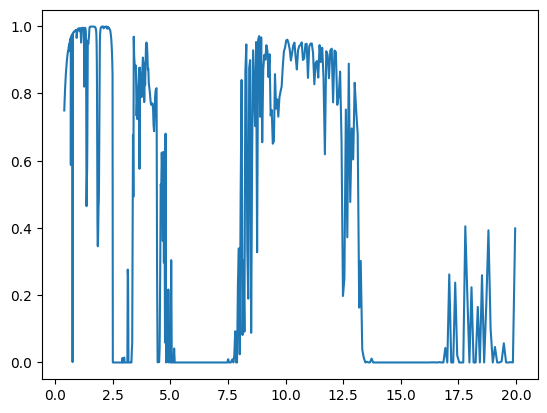

In [3]:
import subprocess
from io import StringIO
import numpy as np
import matplotlib.pyplot as plt
# Define your file path, e.g., "earthConfigTemplate.txt"
file_path = r"C:\Users\Tristan\Downloads\HyPCAR2\earthConfigTemplate.txt"

# Build the command as a list of arguments.
# If you're on Windows and using PowerShell, you might need to specify "curl.exe" instead of "curl"
command = [
    "curl.exe",  # or "curl.exe" on Windows if needed
    "-d", "type=trn",
    "--data-urlencode", f"file@{file_path}",
    "http://localhost:4000/api.php"
]

try:
    # Run the command and capture output and errors.
    result = subprocess.run(
        command,
        stdout=subprocess.PIPE,
        stderr=subprocess.PIPE,
        text=True,  # ensures the output is returned as a string rather than bytes
        check=True  # raises CalledProcessError if the command exits with a non-zero status
    )
    
    # Print the standard output and standard error
    print("Standard Output:")
    data_array = np.loadtxt(StringIO(result.stdout), comments='#')
    # Extract columns 0 and 1 as a list of tuples
    # data_array = list(zip(data_array[:, 0], data_array[:, 1]))[:-1]
    plt.plot(data_array[:, 0], data_array[:, 1])
    print(data_array)

except subprocess.CalledProcessError as e:
    # This will catch errors if the command fails (non-zero exit status)
    print("An error occurred:")
    print(e.stderr)


In [18]:
mseAvg=0
detectionAvg=0
pinnAvg=0
test=0
with open("customLossTesting.txt") as f:
    length=0
    for i,line in enumerate(f):
        if i%2==0:
            #3 values
            values=list(map(float,line.split(",")))

            pinnAvg+=values[0]
            mseAvg+=values[1]
            detectionAvg+=values[2]
            # print(values[0])
            length+=1
    
    # print(length)
    mseAvg/=length
    detectionAvg/=length
    pinnAvg/=length
#Normalizaiont for each.Then can multiply accordingly, to see which one is the most important
mseLambda=(1/mseAvg)/3
detectionLambda=(1/detectionAvg)/3
pinnLambda=(1/pinnAvg) #3 times as important as the others
total=0
with open("customLossTesting.txt") as f:
    length=0
    for i,line in enumerate(f):
        if i%2==0:
            #3 values
            values=list(map(float,line.split(","))) 
            total+=values[0]*pinnLambda+values[1]*mseLambda+values[2]*detectionLambda
            print((values[0]*pinnLambda,values[1]*mseLambda,values[2]*detectionLambda))
            length+=1
print(total/length)
print("Constants:")
print(mseLambda)
print(detectionLambda)
print(pinnLambda)



(0.9960350130405022, 0.3616122088055769, 0.37032751211013687)
(1.008409902453006, 0.3258452703090416, 0.38116636612311655)
(1.0188776982215912, 0.3831919265283618, 0.2854231556751299)
(1.1619121108174042, 0.3550794317618184, 0.3323915230647082)
(0.9547184280228637, 0.37028771647259395, 0.3721339877789669)
(1.0059518107332157, 0.28179754943469676, 0.4028440741490758)
(1.0551776233908856, 0.44879091125876214, 0.3360044744023681)
(0.9535481495031374, 0.32342775237634735, 0.3649080851036471)
(0.9531213494517208, 0.28737357684059095, 0.3883922687984363)
(0.893969841771389, 0.42664193010677254, 0.3360044744023681)
(0.9343410666686769, 0.29793267837860526, 0.3883922687984363)
(1.0084733427928614, 0.3431419832342356, 0.31793971771406865)
(0.9398980832054387, 0.4404159091770604, 0.3847793174607764)
(1.0594753896210864, 0.3281275718940208, 0.3269720960582185)
(0.9781401336965362, 0.3403692851181547, 0.31793971771406876)
(1.0719095434309314, 0.29975873179445045, 0.37394046344779674)
(0.9482235252

In [32]:
import torch

def calculateChiSquared(yPred, yReal, sigma):
    """
    Computes a single chi-squared statistic for the entire batch.

    Parameters:
    -----------
    yPred : torch.Tensor
        Predicted data with shape (batch_size, num_points).
    yReal : torch.Tensor
        Real data with the same shape as yPred.
    sigma : float or torch.Tensor
        Uncertainty value(s); should be broadcastable to (batch_size, num_points).

    Returns:
    --------
    chi2_value : float
        Overall chi-squared value normalized by the total number of points.
    """
    # Calculate squared differences normalized by sigma^2 for each spectral point
    chi2Elements = ((yPred - yReal) ** 2) / (sigma ** 2)
    # Total chi-squared for the batch: sum over both dimensions
    total_chi2 = torch.sum(chi2Elements)
    # Normalize by the total number of data points
    total_points = yPred.numel()  # Equivalent to batch_size * num_points
    chi2_value = total_chi2 / total_points
    return chi2_value.item()  # Return as a Python float

w,t=data_array[:, 0], data_array[:, 1]
combinedData=torch.tensor(list(zip(w,t)), dtype=torch.float32)

print(combinedData)
print(calculateChiSquared(combinedData,combinedData+0.3,0.1))

tensor([[4.0000e-01, 7.4930e-01],
        [4.0200e-01, 7.5358e-01],
        [4.0401e-01, 7.5781e-01],
        ...,
        [1.9766e+01, 8.8263e-04],
        [1.9865e+01, 0.0000e+00],
        [1.9964e+01, 3.9857e-01]])
9.000000953674316


2
Calibrated Sigma: nan
